# K-means clustering
## Agenda

- classical K-means Algorithmの紹介
- data whitening
- scikit-learn apiの確認
- Gap statisticを用いたcentroid数の最適化

## 参考
- [gap statistic](https://uc-r.github.io/kmeans_clustering)
- [gap statistic and python](https://anaconda.org/milesgranger/gap-statistic/notebook)

### Hardware

In [1]:
%%bash
system_profiler SPHardwareDataType | grep -E \
"Model Identifier"\|"Processor Name"\|"Processor Speed"\
\|"Number of Processors"\|"Memory:"

      Model Identifier: MacBookPro13,1
      Processor Name: Dual-Core Intel Core i5
      Processor Speed: 2 GHz
      Number of Processors: 1
      Memory: 16 GB


In [2]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.15.4
BuildVersion:	19E287


### Python

In [3]:
!python -V

Python 3.7.4


### Install packages

In [4]:
pass

### Import

In [5]:
import itertools

import scipy
from scipy.cluster.vq import whiten
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy
import hashlib

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

### 関数

In [6]:
def zscore(X, axis = 0):
    _mean = np.mean(X, axis  = axis)
    _std = np.std(X, axis  = axis)
    _std[_std == 0.0] = 1
    
    return (X - _mean)/_std

## 1. K-means clusteringとは？
### Algorithm

1. 各data pointに対してランダムにclusterを割り振る
2. 各クラスタに割り当てられたdata pointについて重心を計算する
3. 各data pointについて、2で計算された重心からの距離を計算し、距離が一番近いクラスタに割り当て直す
4. 各data pointの所属情報が変化しない場合、終了。それ以外の場合は2に戻る

### 今回の実装前提条件

- 距離はユークリッド距離とする

In [7]:
class K_means:
    def __init__(self, n_clusters, max_iter = 1000, random_seed = 42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_seed = np.random.RandomState(random_seed)
    
    def fit(self, X, out = False):
        cycle = itertools.cycle(range(self.n_clusters)) # イテラブルオブジェクトの要素を無限に繰り返すイテレータ
        self._label = np.fromiter(itertools.islice(cycle, X.shape[0]), dtype = np.int)
        self.random_seed.shuffle(self._label) # 初期クラスタを設定
        label_list = np.zeros(X.shape[0])
        dist_maxtrix = np.zeros((X.shape[0], self.n_clusters))
        iter_count = 0
        self.cluster_centroids = np.zeros((self.n_clusters, X.shape[1]))
        
        while (not np.all(self._label == label_list)) and iter_count < self.max_iter:
            for i in range(self.n_clusters):
                X_g = X[self._label == i, :]
                if X_g.size > 0: # empty array check
                    self.cluster_centroids[i, :] = np.mean(X_g, axis = 0)
            dist_matrix = np.sum((X[:,:, np.newaxis] - self.cluster_centroids.T[np.newaxis, :, :])**2, axis = 1, )
            label_list = self._label
            self._label = np.argmin(dist_matrix, axis  = 1)
            iter_count += 1
        if out:
            return self._label
        
        def predict(self, X):
            dist_matrix = np.sum((X[:,:, np.newaxis] - self.cluster_centroids.T[np.newaxis, :, :])**2, axis = 1)
            labels = np.argmin(dist_matrix, axis  = 1)
            return labels
        

### test

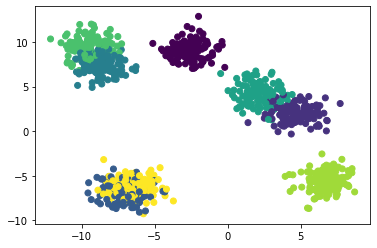

In [8]:
n = 8
k = 2
X, y = make_blobs(1000, n_features=k, centers=n, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c = y);

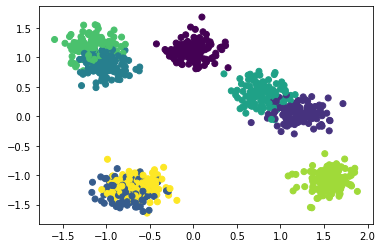

In [9]:
X_norm = zscore(X)
plt.scatter(X_norm[:, 0], X_norm[:, 1], c = y);

In [10]:
model = K_means(n_clusters= n)
y_pred = model.fit(X_norm, out = True)

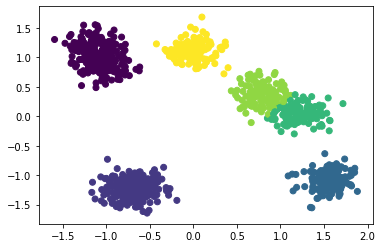

In [11]:
plt.scatter(X_norm[:, 0], X_norm[:, 1], c = y_pred);

## 2. K-means clustering in detail

dataset $X = \{x_1, ..., x_n\} \subset \mathbf R^m$を考える。


### K-means clusterの性質

$C_i \subset X$をK-means algorithmによって分割されたclusterとする。このとき

1. clusters should be pairwise disjoint: $C_i \cap C_j = \emptyset$
2. clusters should cover the data such that: $\bigcap_{i=1}^k C_i = X$
3. data assigned to a cluster $C_i$ should be similar.

### Similarity in K-means Algorithm

- centroid $\mu_i\in \mathbf R^m$とのEuclidean distanceでsimilarityを定義している

K-means algorithmは

$$
E(k) = \sum_{i=1}^k\sum_{x_j\in C_i}z_{ij}||x_j - \mu_i||^2 \text{ where } \ \ z_{ij} = 1\{x_j\in C_i\}
$$
を最小化する問題といえる。ただし、このglobal minimizerを満たすcentroidsを見つけることはNP-hardとされている。

- inertia, or within-cluster sum-of-squares criterionを最小化している


### K-meansの仮定

- clusterがconvex set
- clusterはisotropicでなければならならない

### The Classical k-means Algorithm

```
set k, e, t_max

t <- 0 #iteration
done <- False
randomly initialize mu_1(t), ..., mu_k(t)

while not done do
    // for each mean, update its cluster
    for i = 1 to k do
        C_i(t) = {x in X: ||x - mu_i(t)|| < ||x - mu_j(t)||}
       
    if C_i(t) ∩ C_i(t-1) = C_i(t) for all i
        done <- True
    
    for i = 1 to k do
        n_i = |C_i(t)| # cardinality
        mu_i(t+1) = 1/n_i Σ_{x in C_i(t)} x
    
    if ||mu_i(t+1) - mu_i(t)||<e for all i then
        done <- True
    
    t <- t+1
    if t > t_max then
        done <- True

end while
```

### K-means algorithmの注意点

- Initializationはdata pointに基づいてrandomにclusterを割り振りcentroidを計算した方が良いとされる
- k-means algorithm is tailored to locally Gaussian data
- clusterはcompact convex subsetsである必要がある
- normalization or whitening処理をしたのち、k-means algorithmを適用することが必要
- Time complexity: O(tkn)、クラスターの数と試行回数とサンプル数
- The algorithm is sensitive to outliers

## 3. Data Whitening

- 各成分を互いに無相関にし、平均を 0、分散を 1にすること

### 手法

1. $\{x_i\}_{i=1}^n\subset \mathbf R^k$のcovariance matrix, Sを計算する
2. Sの固有値$\Lambda$, 固有ベクトル$V$を計算する
3. $\{x_i\}_{i=1}^n$をdemeanする
4. $z = \Lambda^{-1/2}Vx_{demean}$を計算する

In [12]:
def whitening(X):
    """
    obs : ndarray
       Each row of the N × k array is an observation vector. The
       columns are the features seen during each observation.
       The features must be whitened first with the `whiten` function.
    """
    X_demean = X - np.mean(X, axis = 0)
    S = np.cov(X, rowvar= 0)
    w, v = np.linalg.eig(S)
    ind = np.argsort(w)[::-1] ## sort descending order
    w = w[ind]
    v = v[:, ind]
    w = 1/np.sqrt(w)
    return (np.diag(w) @ v.T @ X.T).T

In [13]:
np.cov(whitening(X), rowvar=0)

array([[ 1.00000000e+00, -1.97372982e-16],
       [-1.97372982e-16,  1.00000000e+00]])

### Data whiteningとK-means clustering

In [14]:
X_white = whitening(X)
model = K_means(n_clusters= n)
y_pred = model.fit(X_white, out = True)

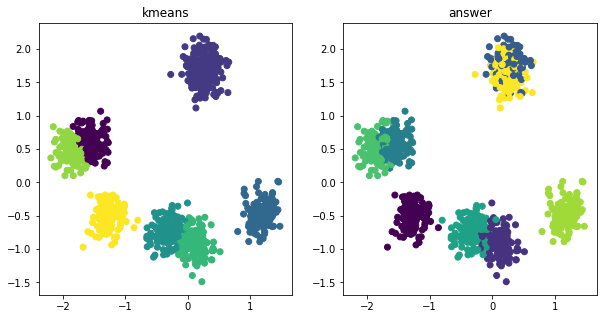

In [15]:
fig, axes = plt.subplots(1,2, figsize = (10,5))
axes[0].scatter(X_white[:, 0], X_white[:, 1], c = y_pred)
axes[1].scatter(X_white[:, 0], X_white[:, 1], c = y)

axes[0].set_title('kmeans')
axes[1].set_title('answer');

## 4. scikit learn APIの確認：Demonstration of k-means assumptions

Text(0.5, 1.0, 'Unevenly Sized Blobs')

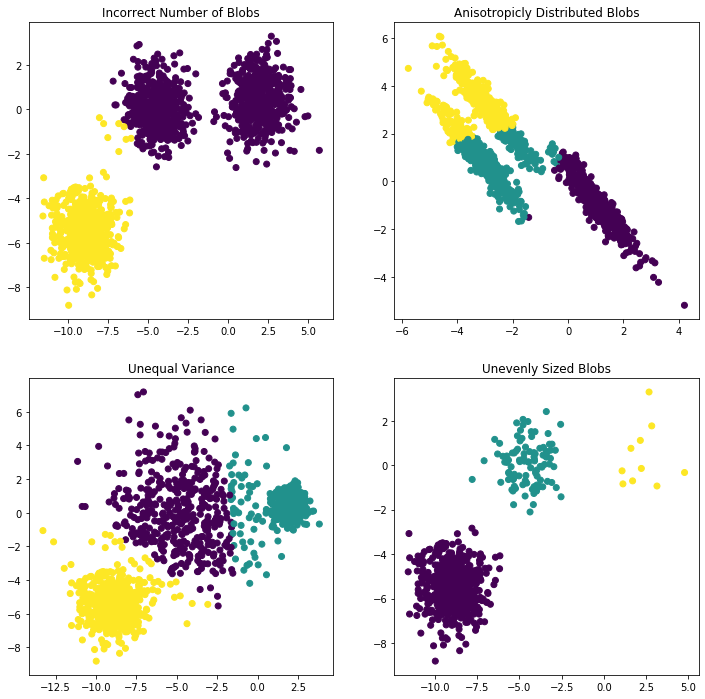

In [16]:
plt.figure(figsize=(12, 12))

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

# Incorrect number of clusters
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Incorrect Number of Blobs")

# Anisotropicly distributed data
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)

plt.subplot(222)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
plt.title("Anisotropicly Distributed Blobs")

# Different variance
X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=random_state)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)

plt.subplot(223)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
plt.title("Unequal Variance")

# Unevenly sized blobs
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_pred = KMeans(n_clusters=3,
                random_state=random_state).fit_predict(X_filtered)

plt.subplot(224)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("Unevenly Sized Blobs")

## 5. Gap statisticを用いたcentroid数の最適化

Elbow MethodやSilhouette methodも有名だが、今回はgap statisticを紹介する。

### gap statisticとは

- K-means clustering, hierarchical clusteringなどany clustering methodに適用可能とされている

$$
Gap_n(k) = E^*_n{log(W_k)} - log(W_k)
$$

- k: the number of clusters
- $W_k = \sum^k_{k=1}W(C_k) = \sum^k_{k=1}\sum_{x_i \in C_k}(x_i - \mu_k)^2$
- $E^*_n$:  the expectation , defined via bootstrapping (B) by generating B copies of the reference datasets

最適なcluster数を$k^*$とすると

$$
k^* = \arg\max_k Gap_n(k)
$$

### Gap statisticの考え方

- Null hypothesisとして、datasetに明確なclusterは存在しない（data pointはuniformly distributed）を設定し、$Gap_n(k)$が最大化されるときは、data pointがuniformly distributedしている状態とは程遠いと解釈している。



### Python Implementation

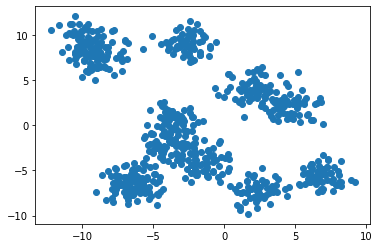

In [17]:
x, y = make_blobs(750, n_features=2, centers=12,random_state=42)

plt.scatter(x[:, 0], x[:, 1])
plt.show()

In [18]:
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal
    

In [19]:
k, gapdf = optimalK(x, nrefs=5, maxClusters=15)
print('Optimal k is: ', k)

Optimal k is:  11


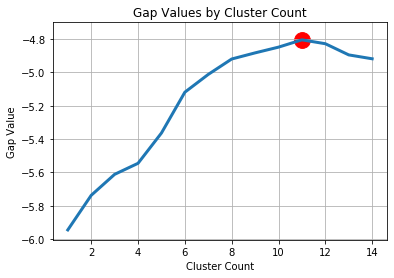

In [20]:
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

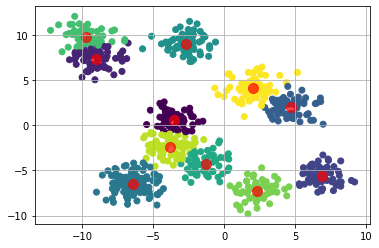

In [21]:
km = KMeans(k)
km.fit(x)

df = pd.DataFrame(x, columns=['x','y'])
df['label'] = km.labels_
df['centroidHash'] = df.label.map(lambda label: hashlib.sha1(str(km.cluster_centers_[label]).encode('utf-8')).hexdigest())

plt.scatter(df.x, df.y, c=df['label'])
    
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], c='r', s=100, alpha=0.7, )
plt.grid(True)


In [22]:
df

,x,y,label,centroidHash
0,-4.689824,-7.688408,4,7cdddbb2926e0335984f8a865c6e09541a928bd2
1,-9.262177,8.147083,1,daf9cbedf05b0c1badfe4e209369a8319e969b9f
2,4.387311,0.725387,3,f4988bfed23ecf81ee590c13a6ed9ea6c581c729
3,-5.929203,-7.457013,4,7cdddbb2926e0335984f8a865c6e09541a928bd2
4,-2.628639,-2.164927,9,3af5cf6427883eda6cbb0800dc8d142025652897
...,...,...,...,...
745,-3.666132,-1.937885,9,3af5cf6427883eda6cbb0800dc8d142025652897
746,6.915903,-4.863587,2,79716221590737104b636ec191198286cd00f748
747,-2.448967,11.477528,5,606ca9f63d91654127a7ae1f6d116013cddebaa9
748,1.848881,-7.039707,8,19e6bc9c32aff8cfc57dd192d3ba8dda1bfd1ffd


## Appendix

### `scipy.cluster.vq.whiten`

- varianceを1にするように調整してくれる
- 不偏分散は用いてない

```python
def whiten(obs, check_finite=True):
    obs = _asarray_validated(obs, check_finite=check_finite)
    std_dev = obs.std(axis=0)
    zero_std_mask = std_dev == 0
    if zero_std_mask.any():
        std_dev[zero_std_mask] = 1.0
        warnings.warn("Some columns have standard deviation zero. "
                      "The values of these columns will not change.",
                      RuntimeWarning)
    return obs / std_dev
```

In [23]:
features  = np.array([[1.9, 2.3, 1.7],
                      [1.5, 2.5, 2.2],
                      [0.8, 0.6, 1.7,]])
whiten(features)

array([[4.17944278, 2.69811351, 7.21248917],
       [3.29956009, 2.93273208, 9.33380951],
       [1.75976538, 0.7038557 , 7.21248917]])

In [24]:
features/np.std(features, ddof = 0, axis = 0)

array([[4.17944278, 2.69811351, 7.21248917],
       [3.29956009, 2.93273208, 9.33380951],
       [1.75976538, 0.7038557 , 7.21248917]])